### Neural Networks  
In this notebook we will create a predictive model using a neural network.  
To do this we will use [Keras](https://keras.io/) with [TensorFlow](https://www.tensorflow.org/).

In [1]:
from typing import Callable
from time import time
import pandas as pd

# for neural networks
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

# for evaluation & preprocessing
from sklearn.model_selection import (
    train_test_split,
    ParameterGrid,
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
)
import sys, os
sys.path.append(os.path.abspath(os.path.join("..")))
from utils.evaluation import mean_average_percentage_error, root_mean_squared_error

# for displaying results & feedback
from tabulate import tabulate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


First we check whether TensorFlow recognizes the GPU.  
The notebook will still run even if the GPU is not available, but it will be slower.
The reason for that is that the GPU is capable of large-scale parallel processing and fitting a neural network can make use of it.

In [2]:
n_gpus = len(tf.config.list_physical_devices('GPU'))
if n_gpus > 0:
	print("GPU recognized by tensorflow 🥳")
else:
	print("No GPU available 😢")

GPU recognized by tensorflow 🥳


2022-01-27 18:11:29.390685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 18:11:29.426080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 18:11:29.426491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
trips_df = pd.read_pickle("../00_data/trips_hourly_selected.pkl")

In [4]:
Y = trips_df["starting_trips"]
X = trips_df.drop(["starting_trips"], axis=1)


n_features = X.shape[1]

Our data is already preprocessed, so we only have to convert the values of binary features `is_weekday` and `is_holiday` to 0 and 1.

In [5]:
X["is_weekday"] = X["is_weekday"].astype("int")
X["is_holiday"] = X["is_holiday"].astype("int")

We split the data into training and test sets. We will train the model and tune the hyperparameters only on the training set.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

We normalize our data with the StandardScaler, which means that the mean and standard deviation of each feature will be 0 and 1 respectively.

In [7]:
X_train_scaled = StandardScaler().fit_transform(X_train)

We now prepare several methods that evaluate the performance of a trained model as well as the training process itself.  
The history dataframe created by `create_history_df` will contain the loss and mae for each epoch as well as the difference between two values of consecutive epochs. This allows us to recognize whether further training is beneficial and whether or not the model is overfitting.

In [8]:
def create_history_df(history):
	history_df = pd.DataFrame(history.history)
	history_df["delta_loss"] = history_df["loss"].diff()
	history_df["delta_val_loss"] = history_df["val_loss"].diff()
	history_df["delta_mae"] = history_df["mae"].diff()
	history_df["delta_val_mae"] = history_df["val_mae"].diff()
	history_df["epoch"] = history_df.index + 1
	return history_df

In [9]:
def plot_history(history: pd.DataFrame):
	# plot mae and val_mae in one plot and delta_mae and delta_val_mae in another plot
	fig = plt.figure(figsize=(12, 6))
	axes = fig.subplots(1, 2)
	axes[0].plot(history["mae"], label="mae")
	axes[0].plot(history["val_mae"], label="val_mae")
	axes[0].set_title("Mean Absolute Error")
	axes[0].legend()

	axes[1].plot(history["delta_mae"], label="delta_mae")
	axes[1].plot(history["delta_val_mae"], label="delta_val_mae")
	axes[1].set_title("Mean Absolute Error (delta)")
	axes[1].legend()

	plt.show()

In [10]:
def print_history_summary(history: pd.DataFrame, duration):
    headers = ["metric", "training", "validation"]
    tabular_data = [
        [
            "Average of last 10 MAE deltas",
            history["delta_mae"].mean(),
            history["delta_val_mae"].mean(),
        ],
        [
            "Last MAE",
            history["mae"].iloc[-1],
            history["val_mae"].iloc[-1],
        ],
        [
            "Last MSE",
            history["loss"].iloc[-1],
            history["val_loss"].iloc[-1],
        ],
        [
            "Epoch with lowest MAE",
            history["epoch"][history["mae"].idxmin()],
            history["epoch"][history["val_mae"].idxmin()],
        ]
    ]

    print(tabulate(tabular_data=tabular_data, headers=headers, tablefmt="grid"))
    print(f"Training duration: {duration:.2f}s")


Initially we will train the models with 100 epochs and a batch size of 32. If we selected the best hyperparameters, we will train the model with more epochs.

In [11]:
def evaluate_model(make_model: Callable, epochs=100, silent=False):
    model = make_model()
    if not silent:
        model.summary()

    start_time = time()
    history = model.fit(
        X_train_scaled,
        Y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=1 if not silent else 0,
    )
    duration = time() - start_time

    history_df = create_history_df(history)

    if not silent:
        plot_history(history_df)
        print_history_summary(history_df, duration)

    return {"history_df": history_df, "model": model, "duration": duration}


#### Training
Before we start the hyperparameter tuning, we will run a simple model as base reference.  
This model will contain a single hidden layer in which the number of nodes is equal to the number of features.  
It will use the ReLU activation function and the mean squared error loss function.  

During training we will already evaluate the performance of the model on a validation split (20% of the training data) with the MAE.

In [12]:
def baseline_model() -> Sequential:
    model = Sequential()
    model.add(Dense(n_features, input_shape=(n_features,), activation="relu"))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
    return model

2022-01-27 18:11:30.016180: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 18:11:30.017033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 18:11:30.017484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 18:11:30.017812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


2022-01-27 18:11:32.191666: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
 76/160 [=============>................] - ETA: 0s - loss: 1031.2866 - mae: 24.7773

2022-01-27 18:11:34.873653: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


160/160 [==============================] - 3s 4ms/step - loss: 1048.7054 - mae: 24.8186 - val_loss: 949.2181 - val_mae: 23.8084
Epoch 2/100
160/160 [==============================] - 1s 3ms/step - loss: 963.3950 - mae: 23.4687 - val_loss: 856.0549 - val_mae: 22.2983
Epoch 3/100
160/160 [==============================] - 1s 3ms/step - loss: 861.1003 - mae: 21.8918 - val_loss: 749.2122 - val_mae: 20.6080
Epoch 4/100
160/160 [==============================] - 1s 3ms/step - loss: 746.9100 - mae: 20.1836 - val_loss: 635.3560 - val_mae: 18.8067
Epoch 5/100
160/160 [==============================] - 1s 3ms/step - loss: 631.4016 - mae: 18.5116 - val_loss: 526.7562 - val_mae: 17.1175
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 524.7075 - mae: 16.9800 - val_loss: 432.4568 - val_mae: 15.6712
Epoch 7/100
160/160 [==============================] - 0s 3ms/step - loss: 433.0894 - mae: 15.7307 - val_loss: 360.4376 - val_mae: 14.5725
Epoch 8/100
160/160 [=================

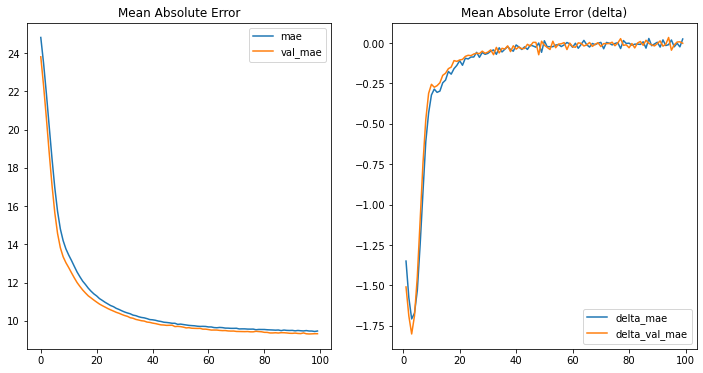

+-------------------------------+------------+--------------+
| metric                        |   training |   validation |
+===============================+============+==============+
| Average of last 10 MAE deltas |  -0.155001 |    -0.146229 |
+-------------------------------+------------+--------------+
| Last MAE                      |   9.47348  |     9.33168  |
+-------------------------------+------------+--------------+
| Last MSE                      | 154.828    |   160.951    |
+-------------------------------+------------+--------------+
| Epoch with lowest MAE         |  99        |    97        |
+-------------------------------+------------+--------------+
Training duration: 56.02s


In [13]:
eval_base = evaluate_model(baseline_model)

#### Hyperparameter Tuning
A neural network has many hyperparameters.

##### Loss Functions
The loss function determines how the model is evaluated. We will use the mean absolute error (MAE) as loss function.

##### Optimizers
The optimizer determines how the model is updated based on the loss function and the gradients computed by the model. 
We will use the Adam optimizer, which is a stochastic gradient descent algorithm. We leave the parameters of the optimizer to the default values (See [Keras documentation](https://keras.io/optimizers/adam)).

##### Epochs
The number of epochs determines how many times the training data is passed through the model. We will start with 100 epochs and if we found all other hyperparameters to be optimal, we will increase the number of epochs. 

##### Batch Size
The batch size determines how many samples are used to update the model at once. There is a lot of discussion about the batch size in the literature. What we can say is that a larger batch size will lead to a faster training process. In our case however, we observed that increasing the batch size decreases the performance of the model. We will therefore stick to a batch size of 32.

##### Activation Functions
The activation function determines how the output of a node is transformed before it is passed to the next nodes. Without it neural networks would simply be a linear combination of the input values and therefore a linear regression model.  
The most common activation functions are the ReLU, the sigmoid and the hyperbolic tangent.


##### Number of Hidden Layers
We will use different numbers of hidden layers. We expect that the performance of the model will improve.

##### Number of Nodes per Hidden Layer
We will use the same number of nodes for each hidden layer, but try different numbers of nodes. We expect that the performance of the model will improve.  




#### Activation functions
We will now try different activation functions, namely the sigmoid function and the hyperbolic tangent function.

In [14]:
def sigmoid_model() -> Sequential:
	model = Sequential()
	model.add(Dense(n_features, input_shape=(n_features,), activation="sigmoid"))
	model.add(Dense(1))

	model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
	return model

In [15]:
def tanh_model() -> Sequential:
	model = Sequential()
	model.add(Dense(n_features, input_shape=(n_features,), activation="tanh"))
	model.add(Dense(1))

	model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
	return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 1s 4ms/step - loss: 1168.9514 - mae: 26.8166 - val_loss: 1079.7778 - val_mae: 26.0275
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 1124.0657 - mae: 26.0376 - val_loss: 1037.6820 - val_mae: 25.2659
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 1082.5270 - mae: 25.2956 - val_loss: 997.9675 - val_mae: 24.5408
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 1042.2428 - mae: 24.601

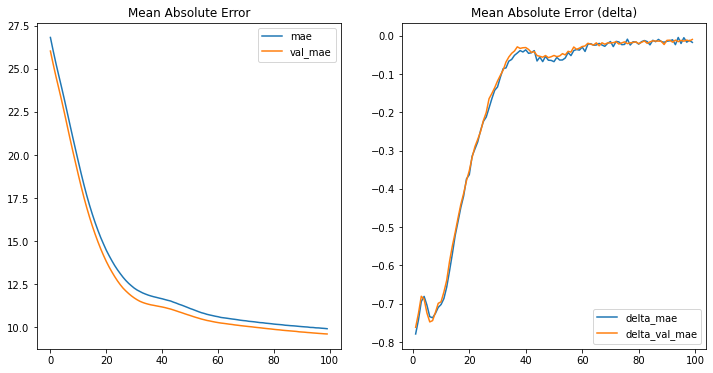

+-------------------------------+------------+--------------+
| metric                        |   training |   validation |
+===============================+============+==============+
| Average of last 10 MAE deltas |  -0.170684 |    -0.165801 |
+-------------------------------+------------+--------------+
| Last MAE                      |   9.91889  |     9.61318  |
+-------------------------------+------------+--------------+
| Last MSE                      | 196.547    |   166.398    |
+-------------------------------+------------+--------------+
| Epoch with lowest MAE         | 100        |   100        |
+-------------------------------+------------+--------------+
Training duration: 40.09s


In [16]:
eval_sigmoid = evaluate_model(sigmoid_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 1s 4ms/step - loss: 1118.1333 - mae: 26.1321 - val_loss: 1033.8009 - val_mae: 25.4878
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 1070.3273 - mae: 25.4963 - val_loss: 971.7092 - val_mae: 24.6176
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 995.7406 - mae: 24.4114 - val_loss: 890.7715 - val_mae: 23.2947
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 912.7339 - mae: 22.9889 -

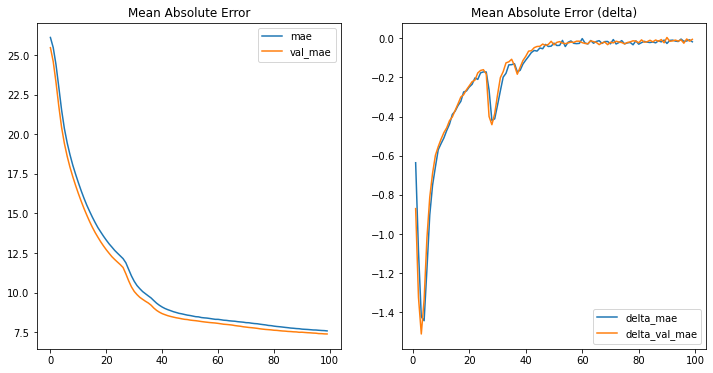

+-------------------------------+------------+--------------+
| metric                        |   training |   validation |
+===============================+============+==============+
| Average of last 10 MAE deltas |  -0.187483 |    -0.182938 |
+-------------------------------+------------+--------------+
| Last MAE                      |   7.57129  |     7.37697  |
+-------------------------------+------------+--------------+
| Last MSE                      | 128.725    |   104.355    |
+-------------------------------+------------+--------------+
| Epoch with lowest MAE         | 100        |   100        |
+-------------------------------+------------+--------------+
Training duration: 36.01s


In [17]:
eval_tanh = evaluate_model(tanh_model)

As we can see the hyperbolic tangent performed best. However, as we are aware of the vanishing gradient problem, we will use both the ReLU and the hyperbolic tangent in our grid search. The vanishing gradient problem can lead to bad performance in deep neural networks (see [this article](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) for more information).

#### Number of Nodes per Hidden Layer and Number of Hidden Layers 
We now take a short look at how the number of nodes per hidden layer and the number of hidden layers affects the performance of the model.

In [18]:
def large_model():
	model = Sequential()
	model.add(Dense(n_features, input_shape=(n_features,), activation="relu"))
	model.add(Dense(n_features, activation="relu"))
	model.add(Dense(n_features, activation="relu"))
	model.add(Dense(1))

	model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
	return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 8         
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 1s 4ms/step - loss: 1126.7716 - mae: 25.9655 - val_loss: 1006.7143 - val_mae: 24.6059
Epoch 2/100
160/160 [==============================] - 0s 3ms/step - loss: 905.9575 - mae: 22.5845 - val_loss: 59

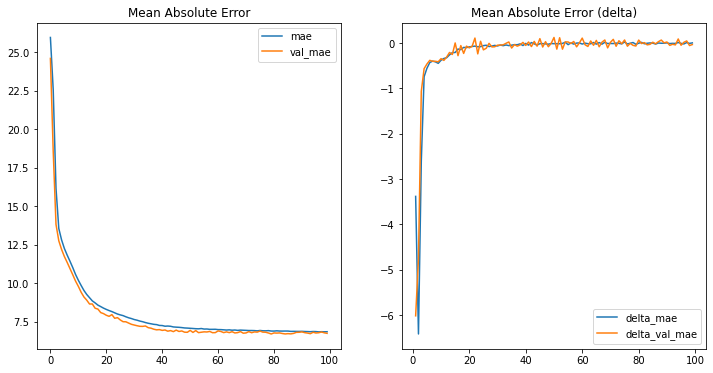

+-------------------------------+------------+--------------+
| metric                        |   training |   validation |
+===============================+============+==============+
| Average of last 10 MAE deltas |  -0.192967 |    -0.180283 |
+-------------------------------+------------+--------------+
| Last MAE                      |   6.86178  |     6.75792  |
+-------------------------------+------------+--------------+
| Last MSE                      |  93.6561   |    98.4747   |
+-------------------------------+------------+--------------+
| Epoch with lowest MAE         |  97        |    80        |
+-------------------------------+------------+--------------+
Training duration: 42.38s


In [19]:
eval_large = evaluate_model(large_model)

In [20]:
def wide_model():
	model = Sequential()
	model.add(Dense(n_features * 2, input_shape=(n_features,), activation="relu"))
	model.add(Dense(1))

	model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
	return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 14)                112       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 15        
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
160/160 [==============================] - 1s 3ms/step - loss: 1073.4753 - mae: 25.2866 - val_loss: 951.1921 - val_mae: 23.9423
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 941.5193 - mae: 23.2160 - val_loss: 792.1492 - val_mae: 21.4275
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 763.1325 - mae: 20.5745 - val_loss: 612.0089 - val_mae: 18.6302
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 591.8902 - mae: 18.1358 -

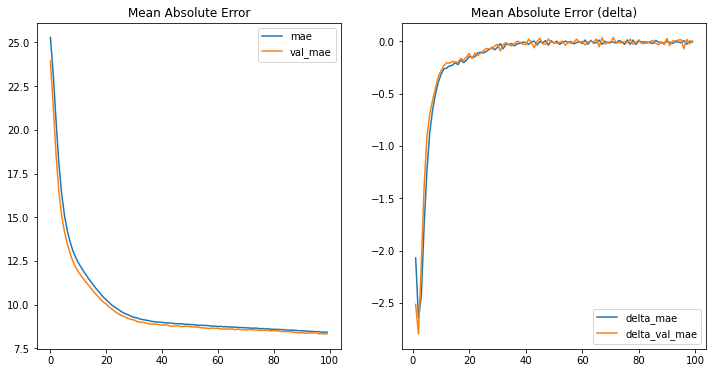

+-------------------------------+------------+--------------+
| metric                        |   training |   validation |
+===============================+============+==============+
| Average of last 10 MAE deltas |  -0.170364 |    -0.157722 |
+-------------------------------+------------+--------------+
| Last MAE                      |   8.42061  |     8.3278   |
+-------------------------------+------------+--------------+
| Last MSE                      | 124.347    |   124.617    |
+-------------------------------+------------+--------------+
| Epoch with lowest MAE         | 100        |    99        |
+-------------------------------+------------+--------------+
Training duration: 40.50s


In [21]:
eval_wide = evaluate_model(wide_model)

As expected the performance of the model improves with increasing the number of hidden layers or the number of nodes per hidden layer.  
We now perform a grid search to find the best hyperparameters.

In [22]:
def make_model(hyperparameters, dropout=0.0):
	model = Sequential()
	activation = hyperparameters["activation"]
	n_hidden_layers = hyperparameters["n_hidden_layers"]
	n_hidden_nodes = hyperparameters["n_hidden_nodes"]

	model.add(Dense(n_hidden_nodes, input_shape=(n_features,), activation=activation))
	for _ in range(n_hidden_layers - 1):
		model.add(Dense(n_hidden_nodes, activation=activation))
		if dropout > 0.0:
			model.add(Dropout(dropout))
	model.add(Dense(1))

	model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])

	return lambda : model

In [23]:
hyperparameter_grid = {
    "activation": ["relu", "tanh"],
    "n_hidden_layers": [1, 2, 4],
    "n_hidden_nodes": [1, n_features, n_features * 2, n_features * 4],
}

# get product of all combinations of hyperparameters
hyperparameter_combinations = list(ParameterGrid(hyperparameter_grid))
len(hyperparameter_combinations)
expected_runtime = len(hyperparameter_combinations) * eval_base["duration"]
print(f"Expected runtime: ~{expected_runtime/60:.2f}min")

results = []
for hyperparameters in tqdm(hyperparameter_combinations):
    evaluation = evaluate_model(make_model(hyperparameters), silent=True)
    results.append({"hyperparameters": hyperparameters, **evaluation})
    tqdm.write(
        f"{hyperparameters} - {evaluation['duration']:.2f}s - mae: {evaluation['history_df']['mae'].iloc[-1]:.2f}"
    )


Expected runtime: ~22.41min


  0%|          | 0/24 [00:00<?, ?it/s]

{'activation': 'relu', 'n_hidden_layers': 1, 'n_hidden_nodes': 1} - 31.05s - mae: 11.76
{'activation': 'relu', 'n_hidden_layers': 1, 'n_hidden_nodes': 7} - 31.88s - mae: 8.51
{'activation': 'relu', 'n_hidden_layers': 1, 'n_hidden_nodes': 14} - 32.69s - mae: 8.36
{'activation': 'relu', 'n_hidden_layers': 1, 'n_hidden_nodes': 28} - 32.27s - mae: 8.05
{'activation': 'relu', 'n_hidden_layers': 2, 'n_hidden_nodes': 1} - 32.63s - mae: 11.80
{'activation': 'relu', 'n_hidden_layers': 2, 'n_hidden_nodes': 7} - 35.21s - mae: 8.30
{'activation': 'relu', 'n_hidden_layers': 2, 'n_hidden_nodes': 14} - 35.13s - mae: 7.06
{'activation': 'relu', 'n_hidden_layers': 2, 'n_hidden_nodes': 28} - 34.57s - mae: 6.37
{'activation': 'relu', 'n_hidden_layers': 4, 'n_hidden_nodes': 1} - 41.13s - mae: 11.78
{'activation': 'relu', 'n_hidden_layers': 4, 'n_hidden_nodes': 7} - 41.17s - mae: 6.54
{'activation': 'relu', 'n_hidden_layers': 4, 'n_hidden_nodes': 14} - 42.33s - mae: 6.03
{'activation': 'relu', 'n_hidden_la

In [24]:
results_df = pd.DataFrame(columns=["activation", "n_hidden_layers", "n_hidden_nodes", "duration", "mae", "val_mae", "delta_val_mae"])
for result in results:
	avg_delta_val_mae = result["history_df"]["delta_val_mae"].iloc[-10:].mean()
	results_df = results_df.append({
		"activation": result["hyperparameters"]["activation"],
		"n_hidden_layers": result["hyperparameters"]["n_hidden_layers"],
		"n_hidden_nodes": result["hyperparameters"]["n_hidden_nodes"],
		"duration": result["duration"],
		"mae": result["history_df"]["mae"].iloc[-1],
		"val_mae": result["history_df"]["val_mae"].iloc[-1],
		"delta_val_mae": avg_delta_val_mae,
	}, ignore_index=True)

In [25]:
results_df.sort_values(by=["val_mae"]).head(5)

,activation,n_hidden_layers,n_hidden_nodes,duration,mae,val_mae,delta_val_mae
23,tanh,4,28,35.002694,5.775401,5.877986,-0.001428
19,tanh,2,28,36.822314,6.107956,5.984473,-0.003549
11,relu,4,28,43.017799,5.861813,5.999385,-0.012262
22,tanh,4,14,34.812527,6.005825,6.007644,-0.009887
18,tanh,2,14,32.325316,6.311558,6.241496,-0.001165


As we can see the the model with the hyperparameters `(relu, 4, 52)` performed best. 
We will now retrain a model with this configuration and increase the number of epochs.  

__Note__: When training neural networks, there is always randomness involved due to the stochastic gradient descent algorithm. Therefore, the performance of the model will not be identical for each run. Therefore the selected hyperparameters are not necessarily the best hyperparameters and can change with each run.

In [26]:
chosen = results_df.sort_values(by=["val_mae"]).head(1)
chosen_hyperparameters = chosen[["activation", "n_hidden_layers", "n_hidden_nodes"]].to_dict()
chosen_id = chosen.index[0]
chosen_hyperparameters = {k: v[chosen_id] for k, v in chosen_hyperparameters.items()}

chosen_hyperparameters

{'activation': 'tanh', 'n_hidden_layers': 4, 'n_hidden_nodes': 28}

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 28)                224       
_________________________________________________________________
dense_93 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_94 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_95 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 29        
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
160/160 [==============================] - 1s 3ms/step - loss: 921.4942 - mae: 23.0798 - val_loss: 685.3

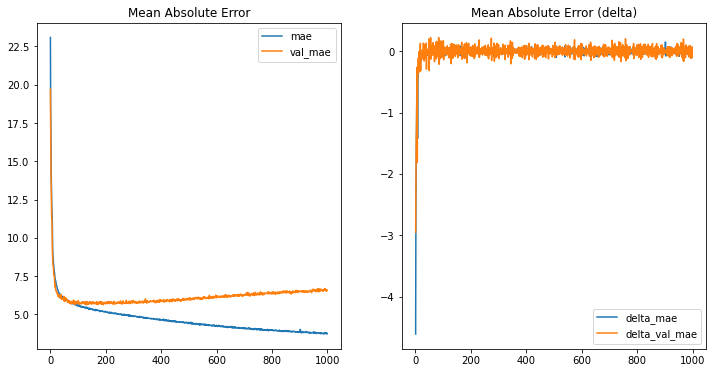

+-------------------------------+-------------+--------------+
| metric                        |    training |   validation |
+===============================+=============+==============+
| Average of last 10 MAE deltas |  -0.0193592 |   -0.0131148 |
+-------------------------------+-------------+--------------+
| Last MAE                      |   3.73993   |    6.59875   |
+-------------------------------+-------------+--------------+
| Last MSE                      |  27.013     |   94.8794    |
+-------------------------------+-------------+--------------+
| Epoch with lowest MAE         | 989         |  130         |
+-------------------------------+-------------+--------------+
Training duration: 483.57s


In [27]:
eval_model = evaluate_model(make_model(chosen_hyperparameters), epochs=1000)

As we can see the model is overfitting. We will therefore add dropout layers to the model.

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 28)                224       
_________________________________________________________________
dense_98 (Dense)             (None, 28)                812       
_________________________________________________________________
dropout (Dropout)            (None, 28)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 28)                812       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 28)                812       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28)              

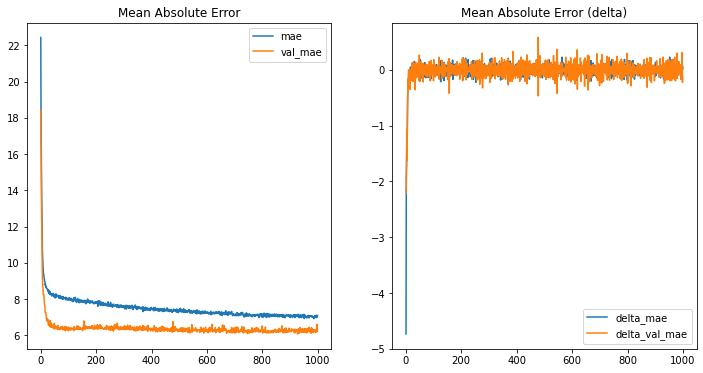

+-------------------------------+-------------+--------------+
| metric                        |    training |   validation |
+===============================+=============+==============+
| Average of last 10 MAE deltas |  -0.0153612 |   -0.0121876 |
+-------------------------------+-------------+--------------+
| Last MAE                      |   7.09088   |    6.24867   |
+-------------------------------+-------------+--------------+
| Last MSE                      | 105.33      |   75.25      |
+-------------------------------+-------------+--------------+
| Epoch with lowest MAE         | 987         |  928         |
+-------------------------------+-------------+--------------+
Training duration: 597.52s


In [28]:
eval_model = evaluate_model(make_model(chosen_hyperparameters, dropout=0.2), epochs=1000)

Our Validation MAE decreased after introducing the dropout layers. However, as the learning seems to be a lot more stable now, we will keep the dropout layers.  
It is not necesary however to train the model with 1000 epochs, as we can see it stabilizes much earlier.  
__Note__: The training error is higher than the validation error in our last model. This is because dropouts layers are used in the training process, but not during validation. 

### Evaluate on test set
We will now evaluate the performance of the model on the test set.

In [29]:
model = eval_model["model"]

X_test_scaled = StandardScaler().fit_transform(X_test)

In [30]:
y_pred = model.predict(X_test_scaled)
y_test = Y_test
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_average_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse:.2f}")

MSE: 95.00
MAE: 6.54
MAPE: 24.29%
RMSE: 9.75
